# KIN 482 Final Project

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

### Introduction   
When performing tasks that require someone to move their unseen hand to a visual target, we typically observe a bias in their end point. Specifcially, in single joint movement tasks that require the participant to extend their joint to the target we see an undershooting (Grose et al., 2021; Eschelmuller et al., 2023). This may indicate that our proprioceptive and visual estimates of hand position are not aligned. In other words, when we complete this task participants must use proprioceptive information about the joint angle and translate this into a visual estimate of hand position. This creates a bias when participants make movements to the target, as they feel as if they are on the target. This creates a phenomena of drift when participants have vision on some trials and then it is removed. A model by Smeets et al., (2006) has been developed to explain this drift phenomena. This model proposes that both the hand and the target have proprioceptive and visual estimates, which when visual feedback is present are aligned. Once vision is removed,  the variance of the visual estimate of the hand and the variance of the proprioceptive estimate of the target increases by a factor of $n\sigma_{ex}$ where $n$ is the number of trials and $\sigma_{ex}$ is the execuation variance. The execuation variance was taken as the error in the baseline trials with full feedback.

--- 

## Smeets et al., (2006) Sensory integration does not lead to sensory calibration
The hand position can be modelled as:
$$\hat{x}_h = \frac{\sigma_v^2+n\sigma_{ex}^2}{\sigma_p^2+\sigma_v^2+n\sigma_{ex}^2}x_{h,p} + \frac{\sigma_v^2}{\sigma_p^2+\sigma_v^2+n\sigma_{ex}^2}x_{h,v}
$$
The target position can be modelled as:
$$\hat{x}_t = + \frac{\sigma_v^2}{\sigma_p^2+\sigma_v^2+n\sigma_{ex}^2}x_{t,p}+\frac{\sigma_v^2+n\sigma_{ex}^2}{\sigma_p^2+\sigma_v^2+n\sigma_{ex}^2}x_{t,v}$$

As can be seen by these equations as $n$ increases, the estimate of $x_h$ will be biased more towards the proprioceptive estimate and the estimate of $x_t$ will be more biased towards the visual estimate. Since these two estimates are not aligned, it creates a bias which leads to the drift that is seen.

The bias can be modelled as:
$$bias = \hat{x}_h - \hat{x}_t$$

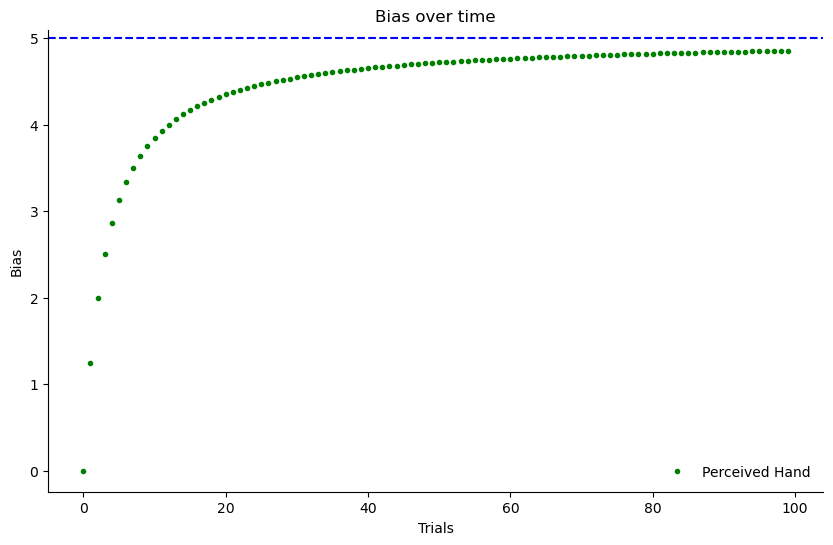

In [3]:
# Smeets model
def calc_hand(prop_mu, vis_mu, prop_sig, vis_sig, ex_sig, n):
    factor1 = (vis_sig+n*ex_sig)/(prop_sig+vis_sig+n*ex_sig)
    factor2 = (prop_sig)/(prop_sig+vis_sig+n*ex_sig)
    return factor1*prop_mu + factor2*vis_mu

def calc_target(prop_mu, vis_mu, prop_sig, vis_sig, ex_sig, n):
    factor1 = (vis_sig)/(prop_sig+vis_sig+n*ex_sig)
    factor2 = (prop_sig+n*ex_sig)/(prop_sig+vis_sig+n*ex_sig)
    return factor1*prop_mu + factor2*vis_mu

def calc_bias(p_mu, v_mu, p_sig, v_sig, ex_sig, n):
    hand = calc_hand(p_mu, v_mu, p_sig, v_sig, ex_sig, n)
    target = calc_target(p_mu, v_mu, p_sig, v_sig, ex_sig, n)
    return hand - target

# Parameters to start with
prop_sig = 1.5
vis_sig = 1.5
ex_sig = 1

prop_mu = 5
vis_mu = 0
bias = prop_mu - vis_mu

biases = []

num_trials = 100

for i in range(num_trials):
    bias_est = calc_bias(prop_mu, vis_mu, prop_sig, vis_sig, ex_sig, i)
    biases.append(bias_est)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(biases, marker='.', linestyle='none', color='green', label='Perceived Hand')
ax.legend(frameon=False)
ax.axhline(bias, color='blue', linestyle='--', label='Actual Bias')
ax.set_title('Bias over time')
ax.set_xlabel('Trials')
ax.set_ylabel('Bias')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Models involving perceived hand position
While the model proposed by Smeets et al., (2006) fits the data well, there are other ways to consider this drift. One way is to consider it a process of minimizing the perceptual error that is generated through the combinration of proprioceptive and visual inputs.

In [4]:
# helper functions
def cue_combination(mu, prec):
    posterior_mu = ((mu[0] * prec[0]) + (mu[1] * prec[1])) / (prec[0] + prec[1])
    sigma = np.sqrt(1/(prec[0] + prec[1]))

    return posterior_mu, sigma

def gaussian_pdf(y, mu, sigma):
    const = 1 / (np.sqrt(2 * np.pi * (sigma**2)))
    exp = np.exp(-(((y - mu) ** 2) / (2 * (sigma**2))))
    return const * exp

def calc_error(mu1, sigma1, mu2, sigma2):
    j1 = 1 / (sigma1**2)  # Precision for the visuial estimate
    j2 = 1 / (sigma2**2)  # Precision for the proprioceptive estimate

    mu3, sigma3 = cue_combination([mu1, mu2], [j1, j2])

    return mu3

def state_space(hand_a, hand_p, target, A, B):
    return A*hand_a + B*(target - hand_p)

def plot_gaussians(mu1, sigma1, mu2, sigma2, mu3, sigma3, hand):
    # Generate x values
    x = np.linspace(-5, 10, 1000)
    # Compute the PDF (Probability Density Function) of the Gaussians
    pdf1 = gaussian_pdf(x, mu1, sigma1)
    pdf2 = gaussian_pdf(x, mu2, sigma2)
    pdf3 = gaussian_pdf(x, mu3, sigma3)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x, pdf1, label='Visual Estimate')
    plt.plot(x, pdf2, label='Proprioceptive Estimate')
    plt.plot(x, pdf3, label='Perceived Hand')
    plt.fill_between(x, pdf1, alpha=0.2)
    plt.fill_between(x, pdf2, alpha=0.2)
    plt.fill_between(x, pdf3, alpha=0.2, linestyle='--')
    plt.axvline(mu1, color='blue', linestyle='-', label='Target Position')
    plt.axvline(hand, color='orange', linestyle='--', label='Actual Hand')
    plt.axvline(mu3, color='green', linestyle='--', label='Perceived Hand')
    plt.ylim(0, 1)
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('Combination of proprioceptive and visual estimates of hand position')
    plt.xlabel('Elbow Angle')
    plt.ylabel('Probability Density')
    plt.legend(frameon=False)
    plt.show()




[4, 3.08, 2.3716, 1.8261319999999999, 1.4061216399999998, 1.0827136627999998, 0.8336895203559997, 0.6419409306741198, 0.4942945166190723, 0.38060677779668567, 0.29306721890344795, 0.22566175855565493, 0.17375955408785426, 0.1337948566476478, 0.10302203961868878, 0.07932697050639036, 0.06108176728992057, 0.047032960813238836, 0.036215379826193904, 0.027885842466169306, 0.021472098698950365, 0.01653351599819178, 0.012730807318607672, 0.009802721635327907, 0.007548095659202489, 0.005812033657585916, 0.004475265916341155, 0.0034459547555826886, 0.0026533851617986702, 0.002043106574584976, 0.0015731920624304317, 0.0012113578880714323, 0.0009327455738150028, 0.0007182140918375521, 0.0005530248507149151, 0.00042582913505048465, 0.0003278884339888732, 0.0002524740941714323, 0.00019440505251200286, 0.0001496918904342422, 0.0001152627556343665, 8.87523218384622e-05, 6.83392878156159e-05, 5.262125161802425e-05, 4.051836374587867e-05, 3.119914008432657e-05, 2.4023337864931457e-05, 1.84979701559972

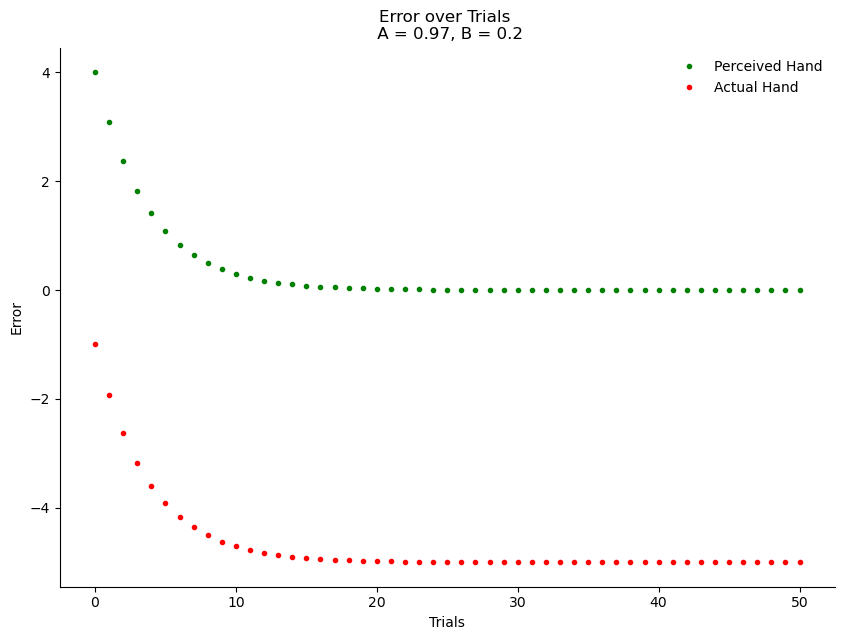

In [8]:
# Simple state space model -----------------------------------------------
bias_v, bias_p = 0, 4
sigma_v, sigma_p = 0.5, 1.5
decay_v = 0.5
decay_p = 0.1
movements = 50

perceived_hand = [bias_p]
hand_actual = [bias_p - bias]
trials = 50
A = 0.97
B = 0.2

for i in range(trials):
    hand = state_space(perceived_hand[-1], perceived_hand[-1], 0, A, B)
    perceived_hand.append(hand)
    hand_actual.append(perceived_hand[-1] - bias)

print(perceived_hand)
plt.figure(figsize=(10,7))
plt.plot(perceived_hand, marker='.', linestyle='none', color='green', label='Perceived Hand')
plt.plot(hand_actual, marker='.', linestyle='none', color='red', label='Actual Hand')
plt.xlabel('Trials')
plt.ylabel('Error')
plt.title(f'Error over Trials \n A = {A}, B = {B}')
plt.legend(frameon=False)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('state_space_sim.svg')
plt.show()

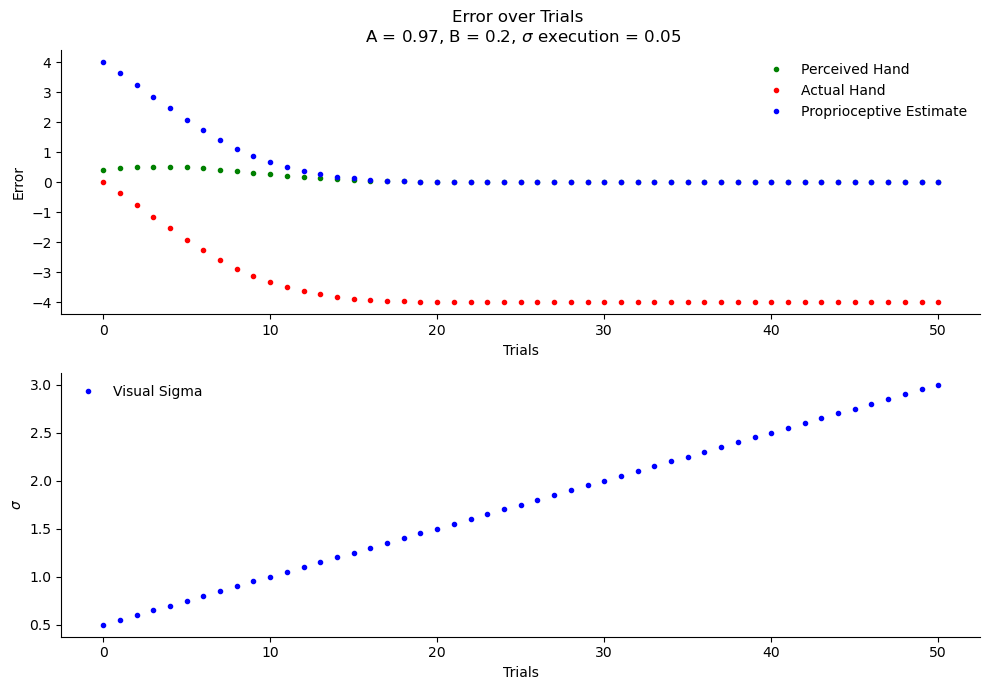

In [11]:
# Model 2
mu1, sigma1 = 0, 0.5  # Mean and standard deviation for the visual estimate
mu2, sigma2 = 4, 1.5  # Mean and standard deviation for the proprioceptive estimate


'''
Visual variance increases over time, so adaptation is ain interplay between this decrease and changes in movement to minmize perceived errror
'''
bias = mu2 - mu1
hand_actual = [mu2 - bias]

mu3, sigma3 = cue_combination([mu1, mu2], [1/sigma1**2, 1/sigma2**2])
# plot_gaussians(mu1, sigma1, mu2, sigma2, mu3, sigma3, hand_actual[0])
perceived_hand = [mu3]
v_sigmas = [sigma1]
mus = [mu2]

trials = 50
A = 0.97
B = 0.2

for i in range(trials):
    sigma1 += 0.05
    v_sigmas.append(sigma1)
    mu3, sigma3 = cue_combination([mu1, mus[-1]], [1/sigma1**2, 1/sigma2**2])
    perceived_hand.append(mu3)
    error = state_space(perceived_hand[-1], perceived_hand[-1], 0, A, B)
    mu2 -= error
    mus.append(mu2)
    hand_actual.append(mu2 - bias)



plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(perceived_hand, marker='.', linestyle='none', color='green', label='Perceived Hand')
plt.plot(hand_actual, marker='.', linestyle='none', color='red', label='Actual Hand')
plt.plot(mus, marker='.', linestyle='none', color='blue', label='Proprioceptive Estimate')
plt.xlabel('Trials')
plt.ylabel('Error')
plt.title(f'Error over Trials \n A = {A}, B = {B}, $\sigma$ execution = {0.05}')
plt.legend(frameon=False)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplot(2,1,2)
plt.plot(v_sigmas, marker='.', linestyle='none', color='blue', label='Visual Sigma')
plt.xlabel('Trials')
plt.ylabel('$\sigma$')
plt.legend(frameon=False)
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()